Notes
-------
This notebook prepares figures for the model presentation

In [1]:
# common imports

from IPython.display import display, HTML
from ipywidgets import *

import seaborn as sns

from sklearn.metrics import confusion_matrix

from LC_MMS import MMS, plot_ROCs, plot_PRCs
from LC_data_prep import load_and_prep_data, load_raw_rows

In [2]:
# adjust settings to show all cols and rows
pd.options.display.max_columns = 80
pd.options.display.max_rows = 20

In [3]:
# to supress Warnings (if you've gotten tired of them) run this cell
import warnings
warnings.filterwarnings("ignore")

In [4]:
%%html
<style>
h1, h2, h3, h4 {
    font-family:serif;
    font-weight:bold;  
}
</style>

In [5]:
display(HTML("<h1>LC bad loans and how to reduce them.</h1>"))

HTML(value='<h1>LC bad loans and how to reduce them.</h1>')

In [6]:
#load the test data
test_df = load_and_prep_data(load_test_data=True)
X = test_df.iloc[:,1:] # predictor variables
y = test_df["DEFAULT"] # response/target variable 

In [7]:
# compute biz metrics
test_bad_vs_good_loans = test_df.DEFAULT.value_counts()

raw_df = load_raw_rows(load_test_data=True)
raw_df_with_labels = test_df[["DEFAULT"]].join(raw_df, lsuffix='_test').reset_index()

total_loan_num = raw_df_with_labels.loan_amnt.count()
total_loan_amt = raw_df_with_labels.loan_amnt.sum()

bad_loans_df = raw_df_with_labels.query("DEFAULT==1")
bad_loan_loss = bad_loans_df.loan_amnt.sum()

good_loans_df = raw_df_with_labels.query("DEFAULT==0")
intrest_earned = (good_loans_df.loan_amnt * ( 1 + good_loans_df.int_rate/12 )**good_loans_df.term 
                 - good_loans_df.loan_amnt).sum()

gross_profit_or_loss = (intrest_earned-bad_loan_loss)
gross_roi = gross_profit_or_loss/total_loan_amt

HTML(value='<h4>The number of loans issued <sup>*)</sup></h4> <h6><sup>*)</sup> by a test data set</h6>')

HTML(value='<h5>Total number of loans: <b>266215</b></h5>')

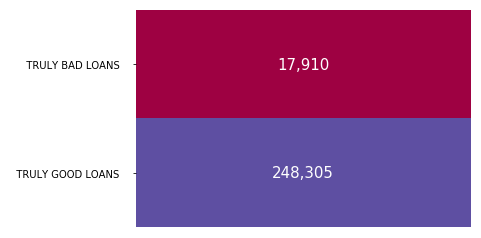

In [8]:
# show the current situation in quantities
display(HTML("<h4>The number of loans issued <sup>*)</sup></h4> <h6><sup>*)</sup> by a test data set</h6>"))
display(HTML("<h5>Total number of loans: <b>{:d}</b></h5>"
             .format(total_loan_num)))

sns.heatmap( test_bad_vs_good_loans[::-1,None],
             cbar=False,
             cmap='Spectral', 
             annot=True,
             fmt=',.0f',
             annot_kws={'size': 15},
             yticklabels=['   TRULY BAD LOANS   ','   TRULY GOOD LOANS   '],
             xticklabels=[]
            );
plt.show()

HTML(value='<h3>In monetary terms</h3>')

HTML(value='<h5>Loans Issued <b>$3,925,567,475</b><br/>Gross Profit/Loss: <b>\\$2,531,370,199</b><br/>Gross ROI: <b>0.645%</b></h5>')

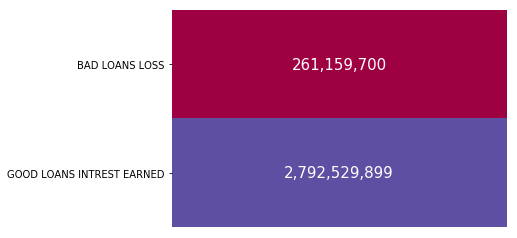

In [9]:
# show the current situation in monetary values
display(HTML("<h3>In monetary terms</h3>"))
display(HTML("<h5>Loans Issued <b>${:,.0f}</b><br/>"
             "Gross Profit/Loss: <b>\${:,.0f}</b><br/>"
             "Gross ROI: <b>{:.3f}%</b></h5>"
             .format(total_loan_amt,
                     gross_profit_or_loss,
                     gross_roi)))

sns.heatmap( [[bad_loan_loss],[intrest_earned]],
             cbar=False,
             cmap='Spectral', 
             annot=True,
             fmt=',.0f',
             annot_kws={'size': 15},
             yticklabels=['BAD LOANS LOSS','GOOD LOANS INTREST EARNED'],
             xticklabels=[],
            );

In [10]:
display(HTML("<h3>Can we reduce the losses?</h3>"))
display(HTML("<h4>If only we could predict which ones will wind up bad ...</h4>"))
display(HTML("<h4>Let's use computers to build a predictive model.</h4>"))

HTML(value='<h3>Can we reduce the losses?</h3>')

HTML(value='<h4>If only we could predict which ones will wind up bad ...</h4>')

HTML(value="<h4>Let's use computers to build a predictive model.</h4>")

In [11]:
# load the pre-tained models
mms = MMS()

best_model_list = mms.list_models()
model_df = pd.DataFrame( best_model_list, 
                        columns=['model_name', 'accuracy', 'precision', 'recall', 'f1', 'neg_log_loss', 'roc_auc'])
model_df = model_df.sort_values(by='roc_auc', ascending=False)

In [12]:
display(HTML("<h3>Computer models and their test characteristics<sup>*)</sup></h3>"))
display(HTML("<h6><sup>*)</sup> developed based on a training data set</h6>"))
display(model_df)

HTML(value='<h3>Computer models and their test characteristics<sup>*)</sup></h3>')

HTML(value='<h6><sup>*)</sup> developed based on a training data set</h6>')

,model_name,accuracy,precision,recall,f1,neg_log_loss,roc_auc
0,LGBMClassifier,0.988359,0.994017,0.827837,0.903512,-0.045308,0.982908
1,StandardScaler-MLPClassifier,0.987412,0.972324,0.828082,0.901095,-0.047627,0.980949
2,GradientBoostingClassifier,0.985423,0.996757,0.780977,0.876857,-0.052836,0.980631
3,RandomForestClassifier,0.985271,0.999245,0.776871,0.873857,-0.084361,0.973064
4,ExtraTreesClassifier,0.984587,0.999299,0.766922,0.867720,-0.089022,0.971741
5,StackingEstimator-StackingEstimator-StackingEs...,0.985255,0.982446,0.787989,0.877260,-0.082770,0.962697
6,DecisionTreeClassifier,0.984827,0.988603,0.783118,0.872868,-0.076041,0.961619
7,LogisticRegression,0.959241,0.596396,0.815029,0.727060,-0.219045,0.952416


In [13]:
display(HTML("<h4>Let's put the best model to the test</h4>"))

# get the best model to predict outcomes
the_best = mms.get_model(by_best_score='roc_auc')
predicted = the_best.predict(X)
expected = y
display(HTML("<h5>The best model by 'ROC AUC' is {:s}</h5>".format(the_best.__class__.__name__)))

HTML(value="<h4>Let's put the best model to the test</h4>")

HTML(value="<h5>The best model by 'ROC AUC' is LGBMClassifier</h5>")

HTML(value='<h4>In mumbers</h6>')

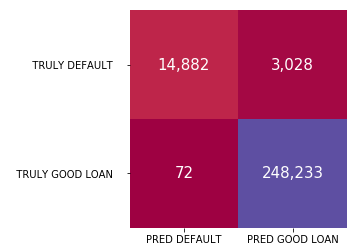

In [14]:
# show the numbers
display(HTML("<h4>In mumbers</h6>"))

cm = confusion_matrix(expected, predicted)
cm = cm[::-1,::-1] # reversed because of habit
sns.heatmap( cm,
             cbar=False,
             cmap='Spectral', 
             annot=True,
             square=True,
             fmt=',d',
             annot_kws={'size': 15},
             yticklabels=['   TRULY DEFAULT   ','   TRULY GOOD LOAN   '],
             xticklabels=['PRED DEFAULT', 'PRED GOOD LOAN']
            );

In [15]:
# compute the $$$

f = pd.DataFrame( np.c_[expected,pd.Series(predicted)], columns=['e','p'] )

P = f[ f.e == 1 ].e.count()
N = f[ f.e == 0 ].e.count()
TP = f [ (f.e == 1) & (f.p == 1) ].p.count()
FP = f [ (f.e == 0) & (f.p == 1) ].p.count()
FN = f [ (f.e == 1) & (f.p == 0) ].p.count()
TN = f [ (f.e == 0) & (f.p == 0) ].p.count()

pred_s = pd.Series(predicted)
pred_s.name = 'PRED'
assert len(pred_s) == len(raw_df_with_labels)

predictions_and_raw_df = pd.concat((pred_s,raw_df_with_labels), axis=1, ignore_index=False).set_index("id")
total_loan_amt = predictions_and_raw_df.loan_amnt.sum()

P_df = predictions_and_raw_df.query("DEFAULT==1")
bad_loan_loss = -1 * P_df.loan_amnt.sum()

N_df = predictions_and_raw_df.query("DEFAULT==0")
good_loan_intrest_earned = (N_df.loan_amnt * ( 1 + N_df.int_rate/12 )**N_df.term - N_df.loan_amnt).sum()

Pred_N_df = predictions_and_raw_df.query("PRED==0")
pred_good_loan_amt = Pred_N_df.loan_amnt.sum()
working_capital_increase = total_loan_amt - pred_good_loan_amt

TP_df = predictions_and_raw_df.query("PRED==1 & DEFAULT==1")
bad_loan_loss_avoided_due_to_TP = (-1 * TP_df.loan_amnt).sum()

FP_df = predictions_and_raw_df.query("PRED==1 & DEFAULT==0")
good_loan_intrest_forfeited_due_to_FP = (FP_df.loan_amnt * ( 1 + FP_df.int_rate/12 )**FP_df.term - FP_df.loan_amnt).sum()

FN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==1")
bad_loan_loss_due_to_FN = (-1 * FN_df.loan_amnt).sum()

TN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==0")
good_loan_intrest_earned_due_to_TN = (TN_df.loan_amnt * ( 1 + TN_df.int_rate/12 )**TN_df.term - TN_df.loan_amnt).sum()

gross_profit = intrest_earned + bad_loan_loss
gross_profit_with_the_pred_model = good_loan_intrest_earned_due_to_TN + bad_loan_loss_due_to_FN
gross_profit_increase = gross_profit_with_the_pred_model - gross_profit

gross_roi = gross_profit/predictions_and_raw_df.loan_amnt.sum()
gross_roi_with_the_pred_model = gross_profit_with_the_pred_model/(FN_df.loan_amnt.sum()+TN_df.loan_amnt.sum())
gross_roi_lift = gross_roi_with_the_pred_model - gross_roi

HTML(value='<h4>In monetary terms</h4>')

HTML(value='<h5>Total Loans Issued <b>$3,706,710,600</b> (Working Capital Increase: <b>\\$218,856,875</b>)<br/>Gross Profit with the model: <b>\\$2,747,183,409</b> (Gross Profit Increase: <b>\\$215,813,210</b>)<br/>Gross ROI with the model: <b>0.741%</b> (Lift:<b>0.096%</b>) </h5>')

HTML(value='<h6><sup>*)</sup> the figures represent the avoided losses and opportunity cost</h6><h6><sup>**)</sup> the figures represent the bad loan losses and good loan interest earned</h6>')

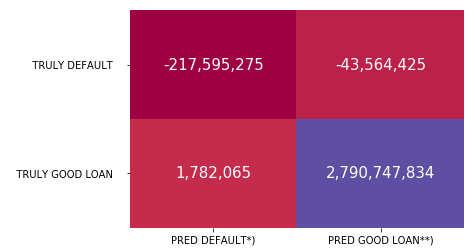

In [16]:
# show me the $$$
display(HTML("<h4>In monetary terms</h4>"))
display(HTML("<h5>Total Loans Issued <b>${:,.0f}</b> (Working Capital Increase: <b>\${:,.0f}</b>)<br/>"
             "Gross Profit with the model: <b>\${:,.0f}</b> (Gross Profit Increase: <b>\${:,.0f}</b>)<br/>"
             "Gross ROI with the model: <b>{:.3f}%</b> (Lift:<b>{:.3f}%</b>) </h5>"
             .format(pred_good_loan_amt, working_capital_increase,
                     gross_profit_with_the_pred_model, gross_profit_increase,
                     gross_roi_with_the_pred_model, gross_roi_lift)))

cm = [
    [bad_loan_loss_avoided_due_to_TP,       bad_loan_loss_due_to_FN],
    [good_loan_intrest_forfeited_due_to_FP, good_loan_intrest_earned_due_to_TN]
]
sns.heatmap( cm,
             cbar=False,
             cmap='Spectral', 
             annot=True,
             fmt=',.0f',
             annot_kws={'size': 15},
             yticklabels=['   TRULY DEFAULT   ','   TRULY GOOD LOAN   '],
             xticklabels=['PRED DEFAULT*)', 'PRED GOOD LOAN**)']
            )

display(HTML("<h6><sup>*)</sup> the figures represent the avoided losses and opportunity cost</h6>"
             "<h6><sup>**)</sup> the figures represent the bad loan losses and good loan interest earned</h6>"))

In [17]:
display(HTML("<h4>Can we do better?</h4>"))
display(HTML("<h4>What if we can change the probability threshold for accepting/denying loans?</h4>"))

HTML(value='<h4>Can we do better?</h4>')

HTML(value='<h4>What if we can change the probability threshold for accepting/denying loans?</h4>')

In [18]:
# show interactive confucion matrix
display(HTML("<h4>Interactive confusion matrix as a function of threshold</h4>"))

raw_df = load_raw_rows(load_test_data=True)
expected = y
raw_df_with_labels = pd.DataFrame(expected).join(raw_df, lsuffix='_test').reset_index()

predict_default_proba = the_best.predict_proba(X)[:,1]


@interact(Threshold=FloatSlider(value=.5,min=0,max=1,step=0.01),
          Pct=Checkbox(value=False,description='Cross tab data as %'))
def plot_confusion_matrix(Threshold,Pct):
    
    if Threshold == 1:
        predicted_t = np.zeros( len(predict_default_proba) )
    elif Threshold == 0:
        predicted_t = np.ones( len(predict_default_proba) )
    else:
        predicted_t = np.where( predict_default_proba >= Threshold, 1, 0) 

    ct = pd.crosstab(expected, predicted_t, 
                     rownames=['Expected'], colnames=['Predicted'], 
                     margins=True, normalize=Pct)
    ct = ct.reindex(index=(1,0,'All'),columns=(1,0,'All'))
    ct.fillna(0,inplace=True)
    
    if Pct:
        ct = ct.applymap( lambda v: '{:.2f}%'.format(100*v) )

    ct.index = ['Truly Bad Loan', 'Truly Good Loan', 'Pred All']
    ct.columns = ['Pred Bad Loan', 'Pred Good Loan', 'Truly All']
    
    pred_t_s = pd.Series(predicted_t)
    pred_t_s.name = 'PRED'
    assert len(pred_t_s) == len(raw_df_with_labels)
    predictions_and_raw_df = pd.concat((pred_t_s,raw_df_with_labels), axis=1, ignore_index=False).set_index("id")
    
    # bad loan losses
    FN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==1")
    bad_loan_loss_with_the_model = -1 * FN_df.loan_amnt.sum()
    print("The threshold for probability of default above which loans are denied: {:d}%".format(int(100*Threshold)))
    print("Bad Loan Losses: {:,.2f}".format(bad_loan_loss_with_the_model))
    
    # interest earned
    TN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==0")
    intrest_earned_with_the_model_s = TN_df.loan_amnt * ( 1 + TN_df.int_rate/12 )**TN_df.term - TN_df.loan_amnt
    intrest_earned_with_the_model = intrest_earned_with_the_model_s.sum()
    print("Interest Earned: {:,.2f}".format(intrest_earned_with_the_model))
    
    # gross profit, ROI
    gross_profit_with_the_model = intrest_earned_with_the_model + bad_loan_loss_with_the_model
    roi_with_the_model = gross_profit_with_the_model/(FN_df.loan_amnt.sum()+TN_df.loan_amnt.sum())
    print("Gross Profit/Loss: {:,.2f}".format(gross_profit_with_the_model))
    print("Gross ROI: {:,.3f}%".format(roi_with_the_model))
    
    return ct



HTML(value='<h4>Interactive confusion matrix as a function of threshold</h4>')

interactive(children=(FloatSlider(value=0.5, description='Threshold', max=1.0, step=0.01), Checkbox(value=False, description='Cross tab data as %'), Output()), _dom_classes=('widget-interact',))

In [19]:
display(HTML("<h4>Can we somehow automate the selection of the optimal threshold?</h4>"))
display(HTML("<h4>Let's try</h4>"))

HTML(value='<h4>Can we somehow automate the selection of the optimal threshold?</h4>')

HTML(value="<h4>Let's try</h4>")

HTML(value='<h4>Gross Profit and ROI as a function of threshold</h4>')

<IPython.core.display.Javascript object>


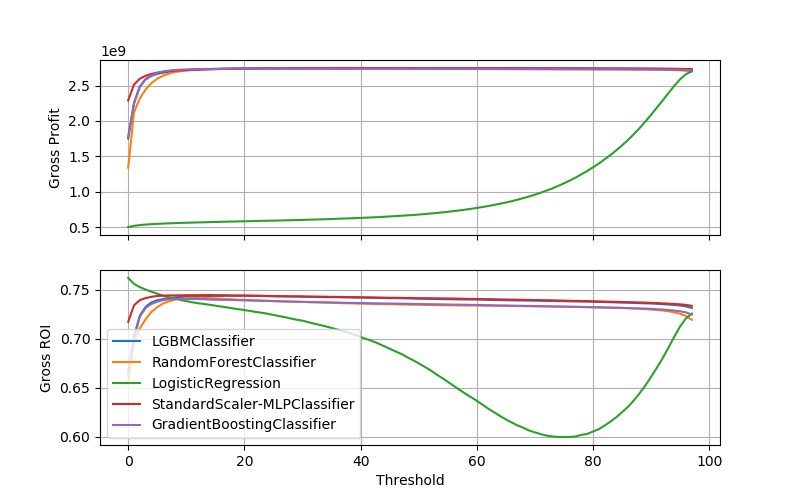

VBox(children=(ToggleButton(value=False, description='LGBMClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='StandardScaler-MLPClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='GradientBoostingClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='RandomForestClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='ExtraTreesClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='StackingEstimator-StackingEstimator-StackingEstimator-DecisionTreeClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='DecisionTreeClassifier', layout=Layout(width='350px')), ToggleButton(value=False, description='LogisticRegression', layout=Layout(width='350px'))))

In [22]:
# show interactive confusion matrix with Gross Profit and ROI
display(HTML("<h4>Gross Profit and ROI as a function of threshold</h4>"))


def compute_profit_and_roi(model):
    
    model = mms.get_model(model)
    
    predict_default_proba = model.predict_proba(X)[:,1]
    gross_profit_or_loss = []
    gross_roi = []

    for Threshold in np.linspace(0.01,.99,98):

        predicted_t = np.where( predict_default_proba >= Threshold, 1, 0) 

        pred_t_s = pd.Series(predicted_t)
        pred_t_s.name = 'PRED'
        assert len(pred_t_s) == len(raw_df_with_labels)
        predictions_and_raw_df = pd.concat((pred_t_s,raw_df_with_labels), axis=1, ignore_index=False).set_index("id")

        # bad loan losses
        FN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==1")
        bad_loan_loss_with_the_model = (-1 * FN_df.loan_amnt).sum()

        # interest earned
        TN_df = predictions_and_raw_df.query("PRED==0 & DEFAULT==0")
        intrest_earned_with_the_model = (TN_df.loan_amnt * ( 1 + TN_df.int_rate/12 )**TN_df.term - TN_df.loan_amnt).sum()
        # gross profit, ROI
        gross_profit_with_the_model = intrest_earned_with_the_model + bad_loan_loss_with_the_model
        roi_with_the_model = gross_profit_with_the_model/(FN_df.loan_amnt.sum()+TN_df.loan_amnt.sum())

        # collect metrics 
        gross_profit_or_loss.append(gross_profit_with_the_model)
        gross_roi.append(roi_with_the_model)

    return gross_profit_or_loss, gross_roi


def plot_lines(model_list):
    
    ax1, ax2 = plt.gcf().get_axes()
    ax1.cla()
    ax2.cla()
    
    for model in model_list:
        gross_profit_or_loss, gross_roi = compute_profit_and_roi(model)
        ax1.plot(gross_profit_or_loss, label=model)
        ax2.plot(gross_roi, label=model)
    
    ax1.set_ylabel("Gross Profit")
    ax1.grid()
    ax2.set_ylabel("Gross ROI")    
    ax2.set_xlabel("Threshold")
    ax2.grid()
    if model_list: ax2.legend()
        
    return


# plot lines
# %matplotlib inline
%matplotlib notebook
# plt.style.use('seaborn-talk')
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True, figsize=(8,5))
ax1.set_ylabel("Gross Profit")
ax2.set_ylabel("Gross ROI")
ax2.set_xlabel("Threshold")
ax1.grid()
ax2.grid()
plt.show();

    
# create and assemble buttons
buttons_w = [ToggleButton(description=model_name,layout=Layout(width='350px')) 
             for model_name in model_df.model_name]
# model_list_to_plot keeps models to use for plotting
model_list_to_plot = []
def toggle_model_plot(d):
    if d.name == 'value' and d.new == True:
        model_list_to_plot.append(d.owner.description)
        plot_lines(model_list_to_plot)
    elif d.name == 'value' and d.new == False:
        model_list_to_plot.remove(d.owner.description)
        plot_lines(model_list_to_plot)
# register buttons' call-backs        
[btn_w.observe(lambda change_value: toggle_model_plot(change_value)) for btn_w in buttons_w]
vbox = VBox(buttons_w)
display(vbox)


In [21]:
display(HTML("<h4>And this is the end of the presentation</h4>"))
display(HTML("<h4>..., but not the end of the story</h4>"))
display(HTML("<h4>What do you make of it?</h4>"))
display(HTML("<h4>Can the predictive models be put to good use?</h4>"))

HTML(value='<h4>And this is the end of the presentation</h4>')

HTML(value='<h4>..., but not the end of the story</h4>')

HTML(value='<h4>What do you make of it?</h4>')

HTML(value='<h4>Can the predictive models be put to good use?</h4>')

### THE END